# Problem3

In [104]:
import os
import random
import math
import copy
import torch
import numpy as np
import torch.optim as optim
import torchvision.datasets as DS
import torch.utils.data as data
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)


# If in clolab environment or not
isColab = False


cuda


### Loading data

In [112]:
if not isColab:
    trainImageFolder = "./trainset/"
    testImageFolder = "./testset/"
else:
    # code here to fetch and load colab folders.
    noop()
    
BATCH_SIZE=512 

# Data augmentation is done through the Randomization of the transforms applied each time an image is loaded in the epoche.
# Each epoche will have different subset of transformations done on the images.
Transform_img = transforms.Compose([
    transforms.RandomRotation((10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
tensor_img_transform = transforms.Compose([transforms.ToTensor()])

# Load from image folder directly, and assign the data augmentaion through the transform
full_dataset = DS.ImageFolder(root=trainImageFolder, transform=Transform_img)

# Seperate the training and validation set: 80% training, 20% validation
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_data, valid_data = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

valid_loader = data.DataLoader(
    valid_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

indices = list(range(len(train_data)))
random.shuffle(indices)
scratch_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    sampler=SubsetRandomSampler(indices[:64]),
    num_workers=1,
    pin_memory=use_cuda
)

### Validate format

This is the shape of one batch of inputs torch.Size([512, 3, 64, 64])
This is the shape of one batch of targets torch.Size([512])
This is an image of class tensor(1)


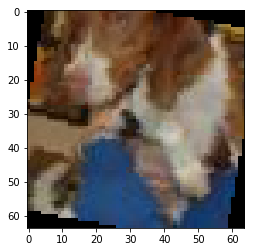

In [113]:
for step, (x, y) in enumerate(train_loader):
    
    print(f"This is the shape of one batch of inputs {x.shape}")
    print(f"This is the shape of one batch of targets {y.shape}")
    print("This is an image of class", y[0])

    img = np.transpose(x[step].numpy(), (1, 2, 0)) # We actually want the chanels in the last column
    plt.imshow(img)
    break

### Model definitions
Heavely inspired from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/ (MIT Liscence)
The BasicBlock is extracted from the repositery, but it's the building block for a resnet with bypass connections. The normalisations were removed since we were not allowed to use them whithout coding them ourselfs. 

In [121]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        
        self.downsample = None
        if inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride),
                # nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)
        
        # Reduce the sample size so the residual matches size
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    def __init__(self):
        super().__init__()
        self.conv1 = conv3x3(3, 64, 2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = BasicBlock(64, 64)
        self.layer2= BasicBlock(64, 128, 2)
        self.layer3= BasicBlock(128, 128)
        self.layer4= BasicBlock(128, 256, 2)
        self.layer5= BasicBlock(256, 256)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(256, 2)
        self.sm = nn.Softmax() # Because we are doing classification. We could use Sigmoid since this is a binary classification, 

    def forward(self, xin):
        x = self.conv1(xin)
       # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = self.layer3(x)
        x = self.layer3(x)
        x = self.layer3(x)
        
        x = self.layer4(x)
        
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)
        x = self.sm(x)
        
        return x
    

### Training

In [122]:
# Surrogate loss used for training
# If we were to use Softmax as our activation in our model, we should actually use Binary Cross Entropy Loss
# nn.BCELoss()
loss_fn = nn.CrossEntropyLoss() 
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## This method comes from the lab session number 11 of the class
def train(model, train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device) # Send data to the device
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))

In [123]:
## This method comes from the lab session number 11 of the class
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            test_size += target.size(0)

            output = model(inputs)
            loss = test_loss_fn(output, target)
            test_loss += loss
            
            pred = output.max(1, keepdim=True)[1]# [1] return s the arg max. i.e.  si idx == target, get the index of the prediction
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

### Overfitting capacity 
We want to validate we have the capacity to at least overfit a small number of examples to make sure our model is at least learning something. This also helps to determin the step size we should use for the longer learning cycles. 

In [64]:
overfit_model = BasicNet().to(device)

lr = 0.05
optimizer = optim.SGD(overfit_model.parameters(), weight_decay=1e-6, lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 45):
    train(overfit_model, scratch_loader, optimizer, epoch)
    loss, acc = test(overfit_model, scratch_loader)


C:\Users\Game\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/64 (0%)]	Loss: 0.691963
Test set: Average loss: 0.6919, Accuracy: 34/64 (53%)

Train Epoch: 2 [0/64 (0%)]	Loss: 0.691853
Test set: Average loss: 0.6918, Accuracy: 34/64 (53%)

Train Epoch: 3 [0/64 (0%)]	Loss: 0.691753
Test set: Average loss: 0.6917, Accuracy: 34/64 (53%)

Train Epoch: 4 [0/64 (0%)]	Loss: 0.691662
Test set: Average loss: 0.6916, Accuracy: 34/64 (53%)

Train Epoch: 5 [0/64 (0%)]	Loss: 0.691578
Test set: Average loss: 0.6915, Accuracy: 34/64 (53%)

Train Epoch: 6 [0/64 (0%)]	Loss: 0.691500
Test set: Average loss: 0.6914, Accuracy: 34/64 (53%)

Train Epoch: 7 [0/64 (0%)]	Loss: 0.691428
Test set: Average loss: 0.6914, Accuracy: 34/64 (53%)

Train Epoch: 8 [0/64 (0%)]	Loss: 0.691362
Test set: Average loss: 0.6913, Accuracy: 34/64 (53%)

Train Epoch: 9 [0/64 (0%)]	Loss: 0.691301
Test set: Average loss: 0.6912, Accuracy: 34/64 (53%)

Train Epoch: 10 [0/64 (0%)]	Loss: 0.691244
Test set: Average loss: 0.6912, Accuracy: 34/64 (53%)

Train Epoch: 11 [0/64 (0%)]	L

In [125]:
model = BasicNet().to(device)

# 0.001 never learned
# 0.1 too mutch?
lr = 0.07
optimizer = optim.SGD(model.parameters(), weight_decay=1e-5, lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )
best_model = None
best_acc = 0
for epoch in range(1, 150):
    train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader) # TODO: change for validation loader!!!!!!!!!!!!!
    
    if (acc > best_acc):
        print("Best acc: ",acc)
        best_model = copy.deepcopy(model)
        best_acc = acc

C:\Users\Game\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/16384 (0%)]	Loss: 0.693509
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.693145
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.693136
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.693067
Test set: Average loss: 0.6930, Accuracy: 2028/4000 (51%)

Best acc:  0.507
Train Epoch: 2 [0/16384 (0%)]	Loss: 0.693041
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.693002
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.693010
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.693099
Test set: Average loss: 0.6929, Accuracy: 2028/4000 (51%)

Train Epoch: 3 [0/16384 (0%)]	Loss: 0.692908
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.693098
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.692852
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.692955
Test set: Average loss: 0.6927, Accuracy: 2030/4000 (51%)

Best acc:  0.5075
Train Epoch: 4 [0/16384 (0%)]	Loss: 0.692746
Train Epoch: 4 [5120/16384 (31%)]	Loss: 0.692489
Train Epoch: 4 [10240/16384 (62%)]	Loss: 0.693239
Train Epoch: 4 [15360/16384 (94%)]	Loss: 0.692778
Test set: Av

Train Epoch: 32 [10240/16384 (62%)]	Loss: 0.655869
Train Epoch: 32 [15360/16384 (94%)]	Loss: 0.675687
Test set: Average loss: 0.6487, Accuracy: 2525/4000 (63%)

Train Epoch: 33 [0/16384 (0%)]	Loss: 0.644999
Train Epoch: 33 [5120/16384 (31%)]	Loss: 0.638892
Train Epoch: 33 [10240/16384 (62%)]	Loss: 0.664310
Train Epoch: 33 [15360/16384 (94%)]	Loss: 0.660358
Test set: Average loss: 0.6750, Accuracy: 2315/4000 (58%)

Train Epoch: 34 [0/16384 (0%)]	Loss: 0.657733
Train Epoch: 34 [5120/16384 (31%)]	Loss: 0.671289
Train Epoch: 34 [10240/16384 (62%)]	Loss: 0.642915
Train Epoch: 34 [15360/16384 (94%)]	Loss: 0.644728
Test set: Average loss: 0.6602, Accuracy: 2412/4000 (60%)

Train Epoch: 35 [0/16384 (0%)]	Loss: 0.648360
Train Epoch: 35 [5120/16384 (31%)]	Loss: 0.639721
Train Epoch: 35 [10240/16384 (62%)]	Loss: 0.638448
Train Epoch: 35 [15360/16384 (94%)]	Loss: 0.631906
Test set: Average loss: 0.6994, Accuracy: 2282/4000 (57%)

Train Epoch: 36 [0/16384 (0%)]	Loss: 0.675631
Train Epoch: 36 [5120/

Train Epoch: 63 [15360/16384 (94%)]	Loss: 0.534071
Test set: Average loss: 0.5485, Accuracy: 3002/4000 (75%)

Best acc:  0.7505
Train Epoch: 64 [0/16384 (0%)]	Loss: 0.516847
Train Epoch: 64 [5120/16384 (31%)]	Loss: 0.542553
Train Epoch: 64 [10240/16384 (62%)]	Loss: 0.540210
Train Epoch: 64 [15360/16384 (94%)]	Loss: 0.527962
Test set: Average loss: 0.5791, Accuracy: 2880/4000 (72%)

Train Epoch: 65 [0/16384 (0%)]	Loss: 0.564232
Train Epoch: 65 [5120/16384 (31%)]	Loss: 0.536872
Train Epoch: 65 [10240/16384 (62%)]	Loss: 0.523727
Train Epoch: 65 [15360/16384 (94%)]	Loss: 0.549923
Test set: Average loss: 0.5701, Accuracy: 2884/4000 (72%)

Train Epoch: 66 [0/16384 (0%)]	Loss: 0.570424
Train Epoch: 66 [5120/16384 (31%)]	Loss: 0.559142
Train Epoch: 66 [10240/16384 (62%)]	Loss: 0.508360
Train Epoch: 66 [15360/16384 (94%)]	Loss: 0.552999
Test set: Average loss: 0.5911, Accuracy: 2807/4000 (70%)

Train Epoch: 67 [0/16384 (0%)]	Loss: 0.553862
Train Epoch: 67 [5120/16384 (31%)]	Loss: 0.577871
Train

Train Epoch: 95 [0/16384 (0%)]	Loss: 0.481441
Train Epoch: 95 [5120/16384 (31%)]	Loss: 0.470030
Train Epoch: 95 [10240/16384 (62%)]	Loss: 0.533224
Train Epoch: 95 [15360/16384 (94%)]	Loss: 0.456252
Test set: Average loss: 0.5217, Accuracy: 3115/4000 (78%)

Train Epoch: 96 [0/16384 (0%)]	Loss: 0.478412
Train Epoch: 96 [5120/16384 (31%)]	Loss: 0.467980
Train Epoch: 96 [10240/16384 (62%)]	Loss: 0.525587
Train Epoch: 96 [15360/16384 (94%)]	Loss: 0.489669
Test set: Average loss: 0.5472, Accuracy: 3003/4000 (75%)

Train Epoch: 97 [0/16384 (0%)]	Loss: 0.521211
Train Epoch: 97 [5120/16384 (31%)]	Loss: 0.519761
Train Epoch: 97 [10240/16384 (62%)]	Loss: 0.454360
Train Epoch: 97 [15360/16384 (94%)]	Loss: 0.506478
Test set: Average loss: 0.5633, Accuracy: 2951/4000 (74%)

Train Epoch: 98 [0/16384 (0%)]	Loss: 0.535312
Train Epoch: 98 [5120/16384 (31%)]	Loss: 0.514041
Train Epoch: 98 [10240/16384 (62%)]	Loss: 0.460860
Train Epoch: 98 [15360/16384 (94%)]	Loss: 0.441195
Test set: Average loss: 0.5590,

Train Epoch: 126 [5120/16384 (31%)]	Loss: 0.411619
Train Epoch: 126 [10240/16384 (62%)]	Loss: 0.443749
Train Epoch: 126 [15360/16384 (94%)]	Loss: 0.404100
Test set: Average loss: 0.5361, Accuracy: 3079/4000 (77%)

Train Epoch: 127 [0/16384 (0%)]	Loss: 0.469146
Train Epoch: 127 [5120/16384 (31%)]	Loss: 0.417713
Train Epoch: 127 [10240/16384 (62%)]	Loss: 0.408782
Train Epoch: 127 [15360/16384 (94%)]	Loss: 0.425369
Test set: Average loss: 0.4870, Accuracy: 3274/4000 (82%)

Best acc:  0.8185
Train Epoch: 128 [0/16384 (0%)]	Loss: 0.427076
Train Epoch: 128 [5120/16384 (31%)]	Loss: 0.505193
Train Epoch: 128 [10240/16384 (62%)]	Loss: 0.387068
Train Epoch: 128 [15360/16384 (94%)]	Loss: 0.429159
Test set: Average loss: 0.4942, Accuracy: 3243/4000 (81%)

Train Epoch: 129 [0/16384 (0%)]	Loss: 0.400035
Train Epoch: 129 [5120/16384 (31%)]	Loss: 0.505950
Train Epoch: 129 [10240/16384 (62%)]	Loss: 0.398476
Train Epoch: 129 [15360/16384 (94%)]	Loss: 0.436346
Test set: Average loss: 0.4975, Accuracy: 32

In [126]:
print(best_acc)

0.8185


### Saving Model

In [160]:
import datetime
date = datetime.date.today().strftime("%B %d, %Y")
best_model.to("cpu")
torch.save(best_model, "best_model_" + date + ".pt")
torch.save(best_model.state_dict(), "best_model_dict_" + date + ".pt")
best_model.to(device)

C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


BasicNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
  )
  (layer3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1

### Optional: loading a model
Just un-comment the necessary lines

In [ ]:

### Load entire model
# loaded_model = torch.load("./best_model_January 30, 2019.pt")
# loaded_model.eval()
# loaded_model.to(device)

### Or, Load state_dict
# model = BasicNet()
# model.load_state_dict("./best_model_dict_January 30, 2019.pt")
# model.eval()
# loaded_model.to(device)


### Generate testing output

In [158]:
testImageFolder = "./testset/"

test_official = DS.ImageFolder(root=testImageFolder, transform=tensor_img_transform)
test_loader_off = data.DataLoader(
    test_official,
    batch_size=1,
    # The sampler is an easy way to say that we're using the elements
    num_workers=1,
    pin_memory=True # Cuda
)
final_results = []
ouput_file = open("finalResults.csv", "w")
# writre headers
ouput_file.write("id,label\n")
for idx, (img, label)  in enumerate(test_loader_off):
    inputs = img.to(device)

    output = best_model(inputs)

    pred = output.max(1, keepdim=True)[1]# [1] return s the arg max. i.e.  si label == target, get the index of the prediction
    class_name_pred = full_dataset.classes[pred.int()]
    # get the file name
    path, filename = os.path.split(test_official.imgs[idx][0]) # (img path, label), no labels for tests, so we want arg[0]
    filename, extension = filename.split(".")
    # save the results
    final_results.append([filename, class_name_pred])
    ouput_file.write(str(filename) + "," + class_name_pred + "\n")
    

ouput_file.close()

C:\Users\Game\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
